In [561]:
from pathlib import Path
from PIL import Image

import pandas as pd
import numpy as np

import torch
from transformers import AutoImageProcessor, AutoProcessor, AutoModel

from numpy.typing import NDArray
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Read file

In [ ]:
try:
    data = pd.read_csv('data\\butterfly_mimics\\images.csv')
    data_info = pd.read_csv('data\\butterfly_info.csv')
except:
    import kagglehub

    # Download latest version
    path = kagglehub.dataset_download("keithpinson/butterfly-mimics-2022")
    data = pd.read_csv(f"{path}/images.csv")
    data_info = pd.read_csv(f"{path}/butterfly_info.csv")

In [563]:
data['path'] = 'C:\\Users\\antig\\OneDrive\\Pulpit\\studia\\sem4\\DM\\project1\\data\\butterfly_mimics\\images\\' + data['image'] + '.jpg'
data.drop(columns='Unnamed: 0', inplace=True)
data.head()

,image,name,stage,side,path
0,ggc1e08cbc,monarch,adult,ventral,C:\Users\antig\OneDrive\Pulpit\studia\sem4\DM\...
1,gh150f104b,tiger,adult,both,C:\Users\antig\OneDrive\Pulpit\studia\sem4\DM\...
2,gh20ab0d9c,black,adult,dorsal,C:\Users\antig\OneDrive\Pulpit\studia\sem4\DM\...
3,gh2d5c8c79,monarch,adult,dorsal,C:\Users\antig\OneDrive\Pulpit\studia\sem4\DM\...
4,gh6adf74a4,pipevine,adult,dorsal,C:\Users\antig\OneDrive\Pulpit\studia\sem4\DM\...


In [564]:
data_info.head()

,Name,Common Name,Species,Yum ?,Real ?,Note
0,black,Black Swallowtail,Papilio polyxenes,yum,mimic,mimics pipevine
1,monarch,Monarch,Danaus plexippus,yuck,real,cardiac glycoside toxins
2,pipevine,Pipevine Swallowtail,Battus philenor,yuck,real,sequesters aristolochic acid
3,spicebush,Spicebush Swallowtail,Papilio troilus,yum,mimic,mimics pipevine
4,tiger,Eastern Tiger Swallowtail,Papilio glaucus,yum,mimic,females may mimic pipevine


In [565]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   853 non-null    object
 1   name    853 non-null    object
 2   stage   853 non-null    object
 3   side    853 non-null    object
 4   path    853 non-null    object
dtypes: object(5)
memory usage: 33.4+ KB


In [566]:
data = data.merge(data_info, right_on="Name", left_on="name")
data["name"] = data["name"].astype("category")
data["Real ?"] = data["Real ?"].astype("category")
data["Yum ?"] = data["Yum ?"].astype("category")


In [567]:
data.drop(columns=['Name', 'Common Name', 'Species', 'stage'], inplace=True)

In [568]:
data.head()

,image,name,side,path,Yum ?,Real ?,Note
0,ggc1e08cbc,monarch,ventral,C:\Users\antig\OneDrive\Pulpit\studia\sem4\DM\...,yuck,real,cardiac glycoside toxins
1,gh150f104b,tiger,both,C:\Users\antig\OneDrive\Pulpit\studia\sem4\DM\...,yum,mimic,females may mimic pipevine
2,gh20ab0d9c,black,dorsal,C:\Users\antig\OneDrive\Pulpit\studia\sem4\DM\...,yum,mimic,mimics pipevine
3,gh2d5c8c79,monarch,dorsal,C:\Users\antig\OneDrive\Pulpit\studia\sem4\DM\...,yuck,real,cardiac glycoside toxins
4,gh6adf74a4,pipevine,dorsal,C:\Users\antig\OneDrive\Pulpit\studia\sem4\DM\...,yuck,real,sequesters aristolochic acid


In [569]:
def show_image(idx: int):
    print(data['name'][idx])
    print(data['Real ?'][idx])
    img = Image.open(data.iloc[idx].path)
    print(img.size)
    display(img)
    

monarch
real
(224, 224)


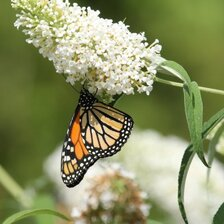

tiger
mimic
(224, 224)


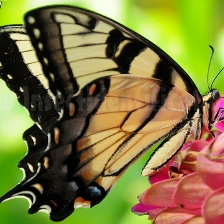

In [570]:
show_image(0)
show_image(1)

# Generating embeddings

1. Histograms
2. Using deep learning approach

In [571]:
def histogram_embeddings(image_path: str | Path):
    image = Image.open(image_path)
    image = np.array(image)
    
    histogram, _ = np.histogram(image, bins=256, range=(0, 256))
    return histogram

In [572]:
# histograms = [image_histogram(p) for p in image_histogram(data['path'])]
histograms = [histogram_embeddings(p) for p in data['path']]

In [573]:
def deep_learning_embeddings(image_path: str | Path, image_processor, model):
    
    image = Image.open(image_path)
    
    inputs = image_processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    if hasattr(outputs, 'pooler_output'):
        embeddings = outputs.pooler_output.numpy()
    else:
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings.squeeze()

In [574]:
# deep_embedings = deep_learning_embeddings(data.iloc[0].path)
    
model_name = "google/efficientnet-b0"
# model_name = "microsoft/resnet-18"
# model_name = "facebook/dinov2-base"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
deep_embeddings = [deep_learning_embeddings(p, image_processor, model) for p in data['path']]

## Plot embeddings

In [575]:
import plotly.express as px

In [576]:
def project_vectors(data, technique: str = "tsne", **options):
    if technique == "pca":
        transformer = PCA(**options)
    elif technique == "tsne":
        transformer = TSNE(**options)
    else:
        raise ValueError(
            f"Invalid technique: {technique}. Choose from 'pca' or 'tsne'."
        )
    data = np.array(data)
    transformed_data = transformer.fit_transform(data)
    return transformed_data

In [577]:
tsne_histograms = project_vectors(histograms, technique="tsne", n_components=2, random_state=0, perplexity=5)
pca_histograms = project_vectors(histograms, technique="pca", n_components=2, random_state=0)

In [578]:
tsne_deep_embeddings = project_vectors(deep_embeddings, technique="tsne", n_components=2, random_state=0, perplexity=5)
pca_deep_embeddings = project_vectors(deep_embeddings, technique="pca", n_components=2, random_state=0)

In [579]:
df_tsne_histograms = pd.DataFrame(tsne_histograms, columns=["x", "y"])
df_tsne_histograms["type"] = data['name']


df_tsne_deep_embedings = pd.DataFrame(tsne_deep_embeddings, columns=["x", "y"])
df_tsne_deep_embedings["type"] = data['name']
df_tsne_deep_embedings["real"] = data['Real ?']
df_tsne_deep_embedings["note"] = data['Note']
df_tsne_deep_embedings["yum"] = data['Yum ?']

In [580]:
df_pca_histograms = pd.DataFrame(pca_histograms, columns=["x", "y"])
df_pca_histograms["type"] = data['name']

df_pca_deep_embedings = pd.DataFrame(pca_deep_embeddings, columns=["x", "y"])
df_pca_deep_embedings["type"] = data['name']
df_pca_deep_embedings["real"] = data['Real ?']
df_pca_deep_embedings["note"] = data['Note']
df_pca_deep_embedings["yum"] = data['Yum ?']

In [581]:
#------------------------------
# TNSE

fig = px.scatter(df_tsne_histograms, x="x", y="y", color="type", title="TSNE histogram embedings")
fig.update_traces(textfont_size=10, marker=dict(size=10))
fig.update_layout(template="plotly")

fig.show()

fig = px.scatter(df_tsne_deep_embedings, x="x", y="y", color="type", title="TSNE deep learning embedings")

fig.update_traces(textfont_size=10, marker=dict(size=10))
fig.update_layout(template="plotly")

fig.show()

#------------------------------
# PCA
fig = px.scatter(df_pca_histograms, x="x", y="y", color="type", title="PCA histogram embedings")
fig.update_traces(textfont_size=10, marker=dict(size=10))
fig.update_layout(template="plotly")

fig.show()

fig = px.scatter(df_pca_deep_embedings, 
                 x="x", 
                 y="y", 
                 color="type", 
                 title="PCA deep learning embedings")

fig.update_traces(textfont_size=10, marker=dict(size=10))
fig.update_layout(template="plotly")

fig.show()

In [582]:
#------------
#TSNE
fig = px.scatter(df_tsne_deep_embedings, 
                 x="x", 
                 y="y", 
                 color="real", 
                 title="TSNE deep learning embedings",
                 hover_data=df_tsne_deep_embedings.columns)

fig.update_traces(textfont_size=10, marker=dict(size=10))
fig.update_layout(template="plotly")

fig.show()

fig = px.scatter(df_tsne_deep_embedings, 
                 x="x", 
                 y="y", 
                 color="yum", 
                 title="TSNE deep learning embedings",
                 hover_data=df_tsne_deep_embedings.columns)

fig.update_traces(textfont_size=10, marker=dict(size=10))
fig.update_layout(template="plotly")

fig.show()

#--------------
# PCA
fig = px.scatter(df_pca_deep_embedings, 
                 x="x", 
                 y="y", 
                 color="real", 
                 title="PCA deep learning embedings",
                 hover_data=df_pca_deep_embedings.columns)

fig.update_traces(textfont_size=10, marker=dict(size=10))
fig.update_layout(template="plotly")

fig.show()

fig = px.scatter(df_pca_deep_embedings, 
                 x="x", 
                 y="y", 
                 color="yum", 
                 title="PCA deep learning embedings",
                 hover_data=df_pca_deep_embedings.columns)

fig.update_traces(textfont_size=10, marker=dict(size=10))
fig.update_layout(template="plotly")

fig.show()

# Learning classifiers

1. KNN classifier
2. Tree-based classifier

In [583]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [584]:
unique_labels = data["name"].unique()

label_mapping  = {label: idx for idx, label in enumerate(unique_labels)}
labels = data["name"].map(label_mapping)
reverse_label_mapping = { value:key for key, value in label_mapping.items()}
label_mapping

{'monarch': 0,
 'tiger': 1,
 'black': 2,
 'pipevine': 3,
 'viceroy': 4,
 'spicebush': 5}

In [585]:
def evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = f1_score(y_test, y_pred, average='macro')
    print(f"F1 Score: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    return accuracy

In [586]:
def visualizing_prediction(idx: int, embedding, model):
    image_path = data.iloc[idx].path
    image_embedding = embedding[idx]

    y_pred = model.predict(image_embedding.reshape(1, -1))
    
    print("Predicted class idx:", y_pred[0])
    print("Predicted class name:", reverse_label_mapping[y_pred[0].item()])
    print("True class name:", data['name'][idx])

    img = Image.open(image_path)
    display(img)

## KNN

In [587]:
# KNN classifier
X_train_whole, X_test_whole, y_train_whole, y_test_whole = train_test_split(
    deep_embeddings, labels, test_size=0.3, stratify=labels, shuffle=True, random_state=23
)

knn_clf_whole = KNeighborsClassifier(n_neighbors=9)
knn_clf_whole.fit(X_train_whole, y_train_whole)

KNeighborsClassifier(n_neighbors=9)

In [588]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    tsne_deep_embeddings, labels, test_size=0.3, stratify=labels, shuffle=True, random_state=23
)
knn_clf_reduced = KNeighborsClassifier(n_neighbors=5) #for n=1  =>  F1=0.7384
knn_clf_reduced.fit(X_train_reduced, y_train_reduced)

KNeighborsClassifier()

Evaluation of KNN classifier on whole embeddings:
K=9
F1 Score: 0.8334

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        39
           1       0.93      0.91      0.92        46
           2       0.82      0.98      0.90        48
           3       0.83      0.93      0.88        58
           4       0.84      0.82      0.83        33
           5       0.88      0.47      0.61        32

    accuracy                           0.86       256
   macro avg       0.86      0.83      0.83       256
weighted avg       0.86      0.86      0.85       256



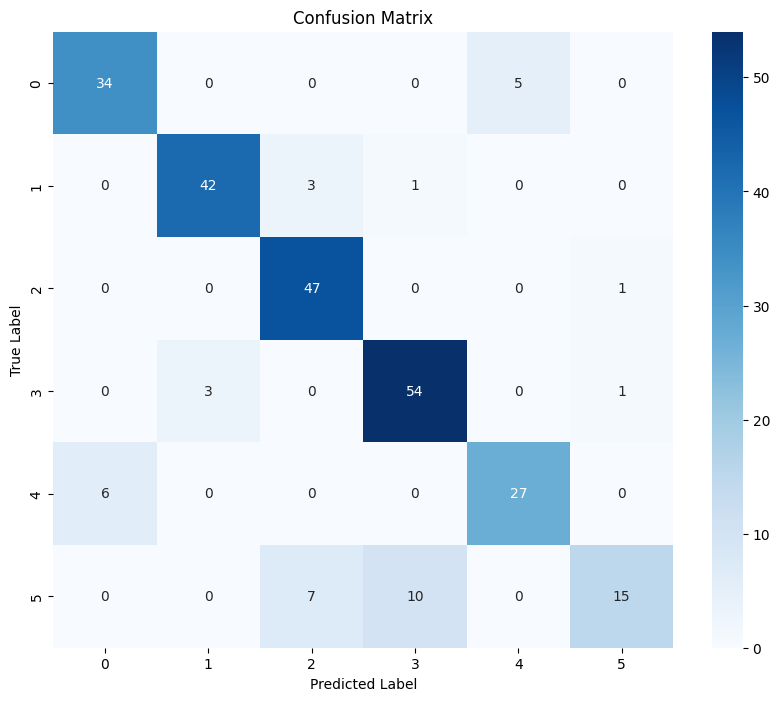

Evaluation of KNN classifier on reduced embeddings:
K=5
F1 Score: 0.7962

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        39
           1       0.85      0.89      0.87        46
           2       0.81      0.88      0.84        48
           3       0.88      0.90      0.89        58
           4       0.78      0.76      0.77        33
           5       0.68      0.53      0.60        32

    accuracy                           0.82       256
   macro avg       0.80      0.80      0.80       256
weighted avg       0.81      0.82      0.81       256



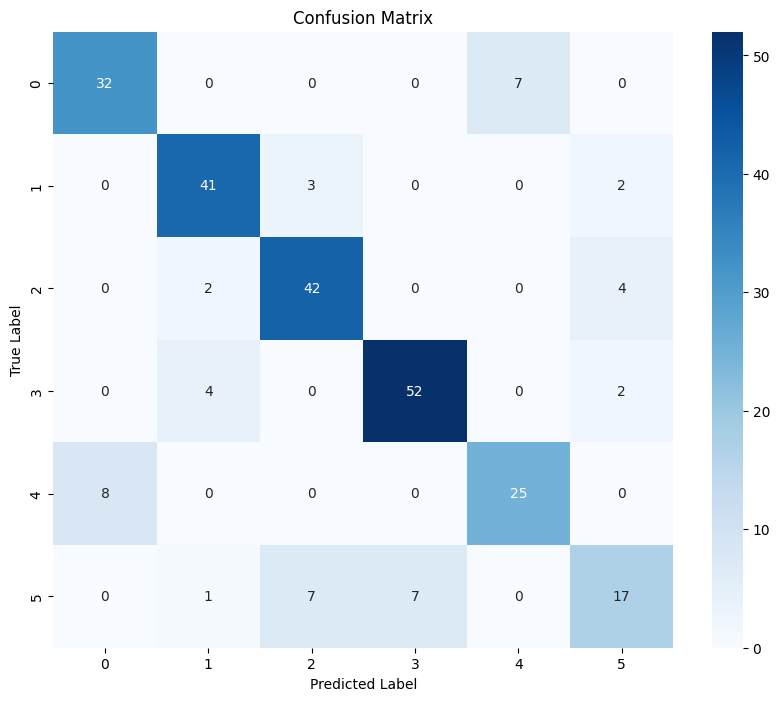

In [589]:
print('Evaluation of KNN classifier on whole embeddings:')
print('K=9')
f1_knn_whole = evaluation(knn_clf_whole, X_test=X_test_whole, y_test=y_test_whole)

print('Evaluation of KNN classifier on reduced embeddings:')
print('K=5')
f1_knn_reduced = evaluation(knn_clf_reduced, X_test=X_test_reduced, y_test=y_test_reduced)

Predicted class idx: 0
Predicted class name: monarch
True class name: monarch


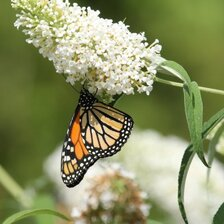

Predicted class idx: 0
Predicted class name: monarch
True class name: monarch


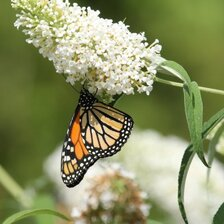

In [590]:
idx = 0
visualizing_prediction(idx, deep_embeddings, knn_clf_whole)
visualizing_prediction(idx, tsne_deep_embeddings, knn_clf_reduced)

Predicted class idx: 1
Predicted class name: tiger
True class name: tiger


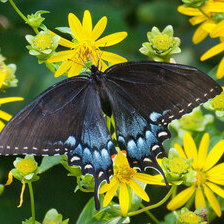

Predicted class idx: 1
Predicted class name: tiger
True class name: tiger


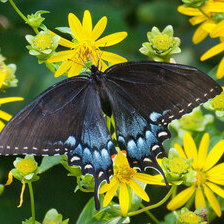

In [591]:
idx = 28
visualizing_prediction(idx, deep_embeddings, knn_clf_whole)
visualizing_prediction(idx, tsne_deep_embeddings, knn_clf_reduced)

## XGBoost

In [592]:
xgb_clf_whole = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.2,
    objective='multi:softprob', 
    eval_metric='mlogloss',
    random_state=23
)

xgb_clf_whole.fit(X_train_whole, y_train_whole)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [593]:
xgb_clf_reduced = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='multi:softprob', 
    eval_metric='mlogloss',
    random_state=23
)

xgb_clf_reduced.fit(X_train_reduced, y_train_reduced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluation of XGB classifier on whole embeddings:
F1 Score: 0.8317

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        39
           1       0.98      0.87      0.92        46
           2       0.82      0.94      0.87        48
           3       0.85      0.91      0.88        58
           4       0.82      0.85      0.84        33
           5       0.72      0.56      0.63        32

    accuracy                           0.85       256
   macro avg       0.84      0.83      0.83       256
weighted avg       0.85      0.85      0.84       256



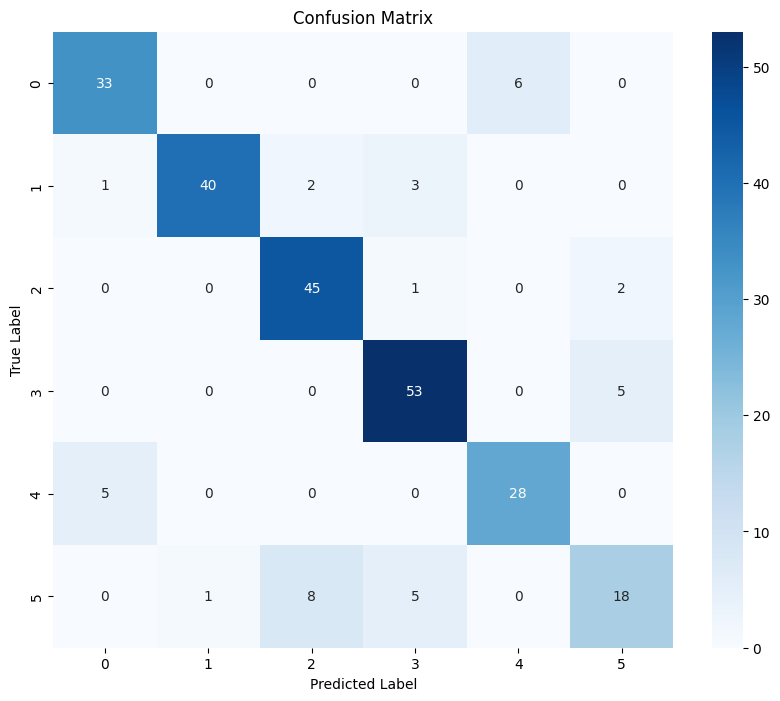

Evaluation of XGB classifier on reduced embeddings:
F1 Score: 0.8019

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        39
           1       0.88      0.93      0.91        46
           2       0.84      0.85      0.85        48
           3       0.86      0.95      0.90        58
           4       0.83      0.73      0.77        33
           5       0.68      0.47      0.56        32

    accuracy                           0.83       256
   macro avg       0.81      0.80      0.80       256
weighted avg       0.82      0.83      0.82       256



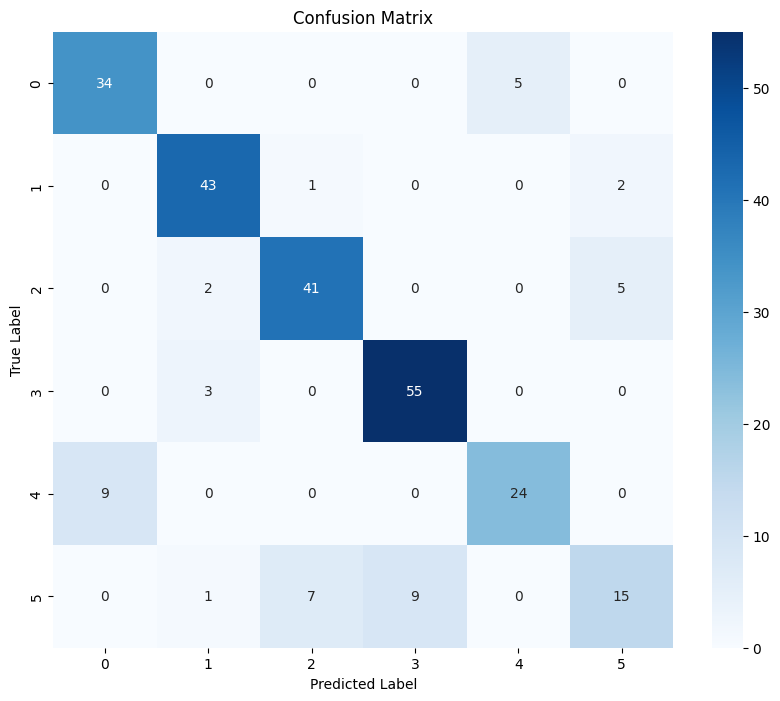

In [594]:
print('Evaluation of XGB classifier on whole embeddings:')
f1_xgb_whole = evaluation(xgb_clf_whole, X_test=X_test_whole, y_test=y_test_whole)

print('Evaluation of XGB classifier on reduced embeddings:')
f1_xgb_reduced = evaluation(xgb_clf_reduced, X_test=X_test_reduced, y_test=y_test_reduced)

Predicted class idx: 0
Predicted class name: monarch
True class name: monarch


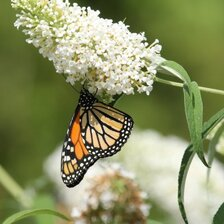

Predicted class idx: 0
Predicted class name: monarch
True class name: monarch


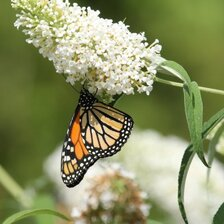

In [595]:
idx = 0
visualizing_prediction(idx, deep_embeddings, xgb_clf_whole)
visualizing_prediction(idx, tsne_deep_embeddings, xgb_clf_reduced)

Predicted class idx: 1
Predicted class name: tiger
True class name: tiger


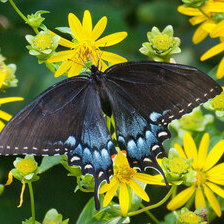

Predicted class idx: 1
Predicted class name: tiger
True class name: tiger


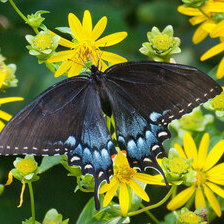

In [596]:
idx = 28
visualizing_prediction(idx, deep_embeddings, knn_clf_whole)
visualizing_prediction(idx, tsne_deep_embeddings, knn_clf_reduced)

In [597]:
from IPython.display import Markdown

# Create markdown table
markdown_table = f"""
| Model              | Whole Embeddings   | Reduced Embeddings  |
|--------------------|--------------------|---------------------|
| KNN                | {f1_knn_whole:.4f} | {f1_knn_reduced:.4f}|
| XGBoost            | {f1_xgb_whole:.4f} | {f1_xgb_reduced:.4f}|
"""

display(Markdown(markdown_table))



| Model              | Whole Embeddings   | Reduced Embeddings  |
|--------------------|--------------------|---------------------|
| KNN                | 0.8334 | 0.7962|
| XGBoost            | 0.8317 | 0.8019|


# Clustering the data
1. K-means
2. hierarchical clustering

In [598]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score

In [599]:
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init = 20, init='k-means++')  # Using 2 clusters to match 'real'/'yum' class
kmeans_labels_2 = kmeans_2.fit_predict(histograms)

kmeans_6 = KMeans(n_clusters=6, random_state=42, n_init = 20, init='k-means++')  # Using 6 clusters to match 'type' class
kmeans_labels_6 = kmeans_6.fit_predict(histograms)

In [600]:
kmeans_labels_dl_2 = kmeans_2.fit_predict(deep_embeddings)
kmeans_labels_dl_6 = kmeans_6.fit_predict(deep_embeddings)

In [601]:
hierarchical_2 = AgglomerativeClustering(n_clusters=2)
hierarchical_6 = AgglomerativeClustering(n_clusters=6)

hierarchical_labels_2 = hierarchical_2.fit_predict(histograms)
hierarchical_labels_6 = hierarchical_6.fit_predict(histograms)
hierarchical_labels_dl_2 = hierarchical_2.fit_predict(deep_embeddings)
hierarchical_labels_dl_6 = hierarchical_6.fit_predict(deep_embeddings)

In [602]:
df_tsne_histograms["Kmeans_Cluster_2"] = kmeans_labels_2
df_tsne_histograms["Kmeans_Cluster_2"] = df_tsne_histograms["Kmeans_Cluster_2"].astype("category")

df_tsne_histograms["Kmeans_Cluster_6"] = kmeans_labels_6
df_tsne_histograms["Kmeans_Cluster_6"] = df_tsne_histograms["Kmeans_Cluster_6"].astype("category")

df_tsne_histograms["Hierarchical_Cluster_2"] = kmeans_labels_2
df_tsne_histograms["Hierarchical_Cluster_2"] = df_tsne_histograms["Hierarchical_Cluster_2"].astype("category")

df_tsne_histograms["Hierarchical_Cluster_6"] = kmeans_labels_6
df_tsne_histograms["Hierarchical_Cluster_6"] = df_tsne_histograms["Hierarchical_Cluster_6"].astype("category")

df_tsne_histograms["real"] = data['Real ?']
df_tsne_histograms["note"] = data['Note']
df_tsne_histograms["yum"] = data['Yum ?']
df_tsne_histograms.head()

,x,y,type,Kmeans_Cluster_2,Kmeans_Cluster_6,Hierarchical_Cluster_2,Hierarchical_Cluster_6,real,note,yum
0,-27.602459,15.698455,monarch,1,5,1,5,real,cardiac glycoside toxins,yuck
1,35.200867,47.986870,tiger,0,1,0,1,mimic,females may mimic pipevine,yum
2,-6.741689,7.336218,black,1,5,1,5,mimic,mimics pipevine,yum
3,1.051422,4.109578,monarch,1,5,1,5,real,cardiac glycoside toxins,yuck
4,-21.234711,-54.538017,pipevine,1,5,1,5,real,sequesters aristolochic acid,yuck


In [603]:
df_tsne_deep_embedings["Kmeans_Cluster_2"] = kmeans_labels_dl_2
df_tsne_deep_embedings["Kmeans_Cluster_2"] = df_tsne_deep_embedings["Kmeans_Cluster_2"].astype("category")

df_tsne_deep_embedings["Kmeans_Cluster_6"] = kmeans_labels_dl_6
df_tsne_deep_embedings["Kmeans_Cluster_6"] = df_tsne_deep_embedings["Kmeans_Cluster_6"].astype("category")

df_tsne_deep_embedings["Hierarchical_Cluster_2"] = kmeans_labels_dl_2
df_tsne_deep_embedings["Hierarchical_Cluster_2"] = df_tsne_deep_embedings["Hierarchical_Cluster_2"].astype("category")

df_tsne_deep_embedings["Hierarchical_Cluster_6"] = kmeans_labels_dl_6
df_tsne_deep_embedings["Hierarchical_Cluster_6"] = df_tsne_deep_embedings["Hierarchical_Cluster_6"].astype("category")

df_tsne_deep_embedings

,x,y,type,real,note,yum,Kmeans_Cluster_2,Kmeans_Cluster_6,Hierarchical_Cluster_2,Hierarchical_Cluster_6
0,33.211895,7.097030,monarch,real,cardiac glycoside toxins,yuck,0,3,0,3
1,34.650925,59.227486,tiger,mimic,females may mimic pipevine,yum,1,4,1,4
2,-21.208437,30.888256,black,mimic,mimics pipevine,yum,1,2,1,2
3,60.375439,-1.100591,monarch,real,cardiac glycoside toxins,yuck,0,3,0,3
4,-62.939537,-3.935610,pipevine,real,sequesters aristolochic acid,yuck,1,5,1,5
...,...,...,...,...,...,...,...,...,...,...
848,-10.850724,21.552734,black,mimic,mimics pipevine,yum,1,2,1,2
849,-13.972286,-43.926804,pipevine,real,sequesters aristolochic acid,yuck,1,1,1,1
850,-14.179057,21.246742,spicebush,mimic,mimics pipevine,yum,1,0,1,0
851,-23.118460,23.842752,spicebush,mimic,mimics pipevine,yum,1,2,1,2


In [604]:
ari_scores_kmeans = [
    ("Kmeans Histogram", "Real / Mimic", adjusted_rand_score(kmeans_labels_2, data["Real ?"].cat.codes)),
    ("Kmeans Histogram", "Yum / Yuck", adjusted_rand_score(kmeans_labels_2, data["Yum ?"].cat.codes)),
    ("Kmeans Histogram", "Type (Name)", adjusted_rand_score(kmeans_labels_6, data["name"].cat.codes)),
    ("Kmeans DeepLearning", "Real / Mimic", adjusted_rand_score(kmeans_labels_dl_2, data["Real ?"].cat.codes)),
    ("Kmeans DeepLearning", "Yum / Yuck", adjusted_rand_score(kmeans_labels_dl_2, data["Yum ?"].cat.codes)),
    ("Kmeans DeepLearning", "Type (Name)", adjusted_rand_score(kmeans_labels_dl_6, data["name"].cat.codes)),
]

# Create the markdown table
md = "| Model Type | Comparison | ARI Score |\n"
md += "|------------|------------|-----------|\n"
for model, comp, score in ari_scores_kmeans:
    md += f"| {model} | {comp} | {score:.4f} |\n"

display(Markdown(md))


| Model Type | Comparison | ARI Score |
|------------|------------|-----------|
| Kmeans Histogram | Real / Mimic | -0.0012 |
| Kmeans Histogram | Yum / Yuck | -0.0003 |
| Kmeans Histogram | Type (Name) | 0.0055 |
| Kmeans DeepLearning | Real / Mimic | 0.0527 |
| Kmeans DeepLearning | Yum / Yuck | 0.2498 |
| Kmeans DeepLearning | Type (Name) | 0.4070 |


In [605]:
ari_scores_hierarchical = [
    ("Hierarchical Histogram", "Real / Mimic", adjusted_rand_score(hierarchical_labels_2, data["Real ?"].cat.codes)),
    ("Hierarchical Histogram", "Yum / Yuck", adjusted_rand_score(hierarchical_labels_2, data["Yum ?"].cat.codes)),
    ("Hierarchical Histogram", "Type (Name)", adjusted_rand_score(hierarchical_labels_6, data["name"].cat.codes)),
    ("Hierarchical DeepLearning", "Real / Mimic", adjusted_rand_score(hierarchical_labels_dl_2, data["Real ?"].cat.codes)),
    ("Hierarchical DeepLearning", "Yum / Yuck", adjusted_rand_score(hierarchical_labels_dl_2, data["Yum ?"].cat.codes)),
    ("Hierarchical DeepLearning", "Type (Name)", adjusted_rand_score(hierarchical_labels_dl_6, data["name"].cat.codes)),
]

# Create the markdown table
md = "| Model Type | Comparison | ARI Score |\n"
md += "|------------|------------|-----------|\n"
for model, comp, score in ari_scores_hierarchical:
    md += f"| {model} | {comp} | {score:.4f} |\n"

display(Markdown(md))


| Model Type | Comparison | ARI Score |
|------------|------------|-----------|
| Hierarchical Histogram | Real / Mimic | 0.0018 |
| Hierarchical Histogram | Yum / Yuck | -0.0010 |
| Hierarchical Histogram | Type (Name) | 0.0041 |
| Hierarchical DeepLearning | Real / Mimic | 0.0754 |
| Hierarchical DeepLearning | Yum / Yuck | 0.2965 |
| Hierarchical DeepLearning | Type (Name) | 0.4066 |


In [606]:
def show_confusion_matrix(true, pred, title="Confusion matrix"):
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

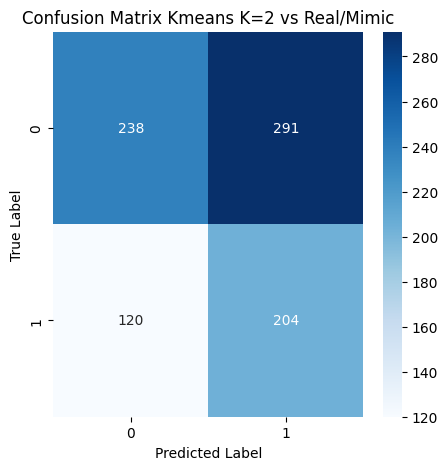

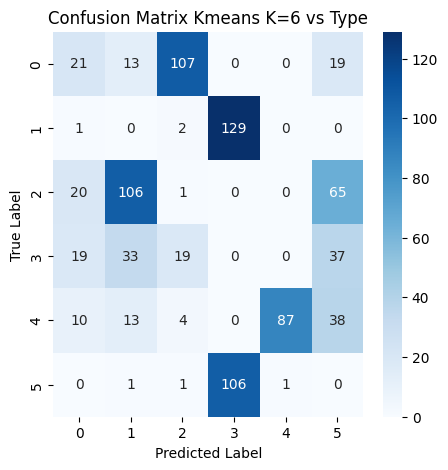

In [607]:
# Confusion matrix
show_confusion_matrix(data["Real ?"].cat.codes, kmeans_labels_2, 'Confusion Matrix Kmeans K=2 vs Real/Mimic')
show_confusion_matrix(data["name"].cat.codes, kmeans_labels_dl_6, 'Confusion Matrix Kmeans K=6 vs Type')

## Visualization

In [608]:
def vizualize_clusterings(data, x, y, color, title):
    fig = px.scatter(data, x=x, y=y, color=color, title=title)
    fig.update_traces(textfont_size=10, marker=dict(size=10))
    fig.update_layout(template="plotly")

    fig.show()

In [609]:
#------------------------------
# Kmeans n = 2
vizualize_clusterings(df_tsne_histograms, "x", "y", "Kmeans_Cluster_2", "TSNE histogram embedings - Kmeans K = 2")
vizualize_clusterings(df_tsne_histograms, "x", "y", "real", "TSNE histogram embedings - Real/Mimic")
vizualize_clusterings(df_tsne_histograms, "x", "y", "yum", "TSNE histogram embedings - Yum/Yuck")
print()

#---------------------------
# Kmeans n = 6

vizualize_clusterings(df_tsne_histograms, "x", "y", "Kmeans_Cluster_6", "TSNE histogram embedings - Kmeans K = 6")
vizualize_clusterings(df_tsne_histograms, "x", "y", "type", "TSNE histogram embedings - Type")


In [610]:
#------------------------------
# Kmeans n = 2
vizualize_clusterings(df_tsne_deep_embedings, "x", "y", "Kmeans_Cluster_2", "TSNE deep embedings - Kmeans K = 2")
vizualize_clusterings(df_tsne_deep_embedings, "x", "y", "real", "TSNE deep embedings - Real/Mimic")
vizualize_clusterings(df_tsne_deep_embedings, "x", "y", "yum", "TSNE deep embedings - Yum/Yuck")
print()

#---------------------------
# Kmeans n = 6

vizualize_clusterings(df_tsne_deep_embedings, "x", "y", "Kmeans_Cluster_6", "TSNE deep embedings - Kmeans K = 6")
vizualize_clusterings(df_tsne_deep_embedings, "x", "y", "type", "TSNE deep embedings - Type")


In [611]:
#------------------------------
# Hierarchical n = 2
vizualize_clusterings(df_tsne_histograms, "x", "y", "Hierarchical_Cluster_2", "TSNE histogram embedings - Hierarchical K = 2")
vizualize_clusterings(df_tsne_histograms, "x", "y", "real", "TSNE histogram embedings - Real/Mimic")
vizualize_clusterings(df_tsne_histograms, "x", "y", "yum", "TSNE histogram embedings - Yum/Yuck")
print()

#---------------------------
# Hierarchical n = 6

vizualize_clusterings(df_tsne_histograms, "x", "y", "Hierarchical_Cluster_6", "TSNE histogram embedings - Hierarchical K = 6")
vizualize_clusterings(df_tsne_histograms, "x", "y", "type", "TSNE histogram embedings - Type")


In [612]:
#------------------------------
# Kmeans n = 2
vizualize_clusterings(df_tsne_deep_embedings, "x", "y", "Hierarchical_Cluster_2", "TSNE deep embedings - Hierarchical K = 2")
vizualize_clusterings(df_tsne_deep_embedings, "x", "y", "real", "TSNE deep embedings - Real/Mimic")
vizualize_clusterings(df_tsne_deep_embedings, "x", "y", "yum", "TSNE deep embedings - Yum/Yuck")
print()

#---------------------------
# Kmeans n = 6

vizualize_clusterings(df_tsne_deep_embedings, "x", "y", "Hierarchical_Cluster_6", "TSNE deep embedings - Hierarchical K = 6")
vizualize_clusterings(df_tsne_deep_embedings, "x", "y", "type", "TSNE deep embedings - Type")
